# A vanilla Machine Learning Workflow for Credit Risk Modeling
<br/>
We have discussed the use of Machine Learning (ML) to support loan approval decisions in the lending business. More specifically, we discussed how supervised ML facilitates estimating the probability of credit applicants to repay debt. Recall that, in banking jargon, a failure to repay debt is called a *default* event. For example, a common definition of a default event is when a borrower is 90 days or more past due on a payment (e.g., an installment). It is common practice to frame probability of default (PD) modeling as a binary classification problem, where the goal is to predict whether a borrower will default or not. In this context, the term *binary* refers to the two possible outcomes: default (1) or no default (0).

In this demo, we will explore the PD modeling problem in detail, going through the various stages of a typical ML workflow, from initial data screening and explanatory data analysis (EDA) to sophisticated predictive modeling and  post-hoc analysis. The purpose of this notebook is to i) give you a feeling of what a standard (supervised) ML workflow looks like and ii) how Python and selected Python libraries support this workflow.

Here's a brief overview of what you'll encounter in the demo:

1. Data Preprocessing: We begin with exploratory data analysis (EDA), where we'll see how to use visual and statistical methods to understand our data's main characteristics. This foundation helps us discern the story our data tells and guides subsequent steps. Furthermore, this step helps us to spot data quality problems, which we should fix before moving on.
   
2. Explanatory Modeling: Next, we build an explanatory model using (logistic) regression. A regression model allows us to understand the relationships in our data. This process involves not just building the model but also interpreting the results, providing us with valuable insights into the dataset's features.

3. Predictive Modeling: Armed with insights from our explanatory model, we'll move into predictive modeling. Here, the aim shifts to creating models that can predict outcomes based on the data. We'll reuse our *Logistic Regression* as a baseline and add a powerful ML approach called  *XGBoost*.
   
4. Post-hoc Analysis: After our predictions models are built and evaluated, we'll delve into post-hoc analysis, dissecting the models' decisions and interpreting their significance. This stage enhances our understanding of model behavior and the importance of different features, reinforcing the concept that effective machine learning involves both prediction and interpretation.

Note how these steps mimic the standardized ML process, which we discussed in the lecture:

![A process perspective towards machine learning](https://raw.githubusercontent.com/Humboldt-WI/demopy/main/ml_pipeline.png)

As we proceed, remember that this notebook isn't just a place to read code – it's an interactive environment where you can run cells, alter code, and see the results immediately. We deleted all cell outputs so that you must, at least, execute every coding cell to experience the demo. Furthermore,  you're encouraged to play around with the codes, make mistakes, ask questions, and most importantly, enjoy the process of discovery.

## Python libraries
Much of the functionality that has made Python the language of choice for ML is provided in auxiliary libraries. For start, we import a couple of standard libraries, which appear in pretty much any machine learning project.

In [1]:
import numpy as np  # linear algebra
import matplotlib.pyplot as plt  # popular plotting library
import seaborn as sns  # yet another popular plotting library
import pandas as pd  # the go-to library for loading, storing, and manipulating tabular data

## 1. Data Preprocessing

### Retrieve the data
For this demo, we consider the *Home Equity (HMEQ)* data set from the textbook [Credit Risk Analytics](http://www.creditriskanalytics.net). It comprises information about a set of borrowers, which are categorized along demographic features and features concerning their business relationship with the lender. A binary target variable called 'BAD' is provided and indicates whether a borrower has repaid their debt. Here is an overview of the data:
- BAD: the target variable, 1=default; 0=non-default
- LOAN: amount of the loan request
- MORTDUE: amount due on an existing mortgage
- VALUE: value of current property
- REASON: DebtCon=debt consolidation; HomeImp=home improvement
- JOB: occupational categories
- YOJ: years at present job
- DEROG: number of major derogatory reports
- DELINQ: number of delinquent credit lines
- CLAGE: age of oldest credit line in months
- NINQ: number of recent credit inquiries
- CLNO: number of credit lines
- DEBTINC: debt-to-income ratio

As you can see, the features aim to describe the financial situation of a borrower, which should probably tell us something about the risk of a borrower to default.

Using the `Pandas` library, we can retrieve the data right from the web; specifically the GitHub repository of this course.

In [2]:
data_location = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq.csv'
df = pd.read_csv(data_location)  # standard pandas function to load tabular data in CSV format
df.head(5)  # obtain a preview of the data by showing the first 5 rows of the table

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [25]:
df.head(15)
print(df.shape)
df.describe()


(5960, 13)


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


### Descriptive Statistics

Having loaded the data, our first task is to get an initial understanding of the data. Enter EDA – a powerful tool that summarizes the main characteristics of our data, offering a quick snapshot and insight without the need to perform complex computations.

We begin with the ```pd.DataFrame.info()``` method, a vital first step that reveals the high-level structure of our data frame. This function provides us with essential details such as the number of entries (eg, rows), the data types of each feature (ie, column), and the amount of non-null values. Understanding this information is crucial as it sets the stage for further analysis and preprocessing by giving us a clear picture of our dataset's composition, especially concerning data types and missing values.

Next, we'll apply the ```pd.DataFrame.describe()``` method, a convenient `Pandas` function that computes a suite of summary statistics for each column in our dataset. Whether you're curious about the average debt-to-income ratio, the variation in loan amounts, or the largest outstanding debt on a mortgage, `describe()` offers a comprehensive overview at a glance.

But why are these steps essential? Both ```info()``` and ```describe()``` help us establish a foundational understanding of our dataset's distribution, scale, and tendencies. While ```info()``` gives us a structural overview, ```describe()``` takes us a step further into the statistical nature of each column. By noting aspects like the mean, standard deviation, and various percentiles, we can detect outliers, identify patterns, and formulate hypotheses for further investigation.

Together, these methods serve as our initial checkpoint, ensuring that we're not only aware of the dataset's composition but also intimately acquainted with its statistical properties. This knowledge is instrumental in guiding our next steps, be it data cleaning, feature selection, or exploratory analysis, as we progress further into our data exploration journey.

In [26]:
df.info() # Obtain information about the structure and characteristics of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


Apparently, our dataset includes both, numerical and categorial features. This follows from the data type of the columns shown as the rightmost entry in the previous output. We can also learn that our data exhibits missing values. We come back to this point later. For now, make sure you see how the above output informs us about the presence of missing values.

Let's move on with seeing the second function, `.describe()` in action.

In [27]:
df.describe() # Compute summary statistics for all numerical features

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


<Axes: >

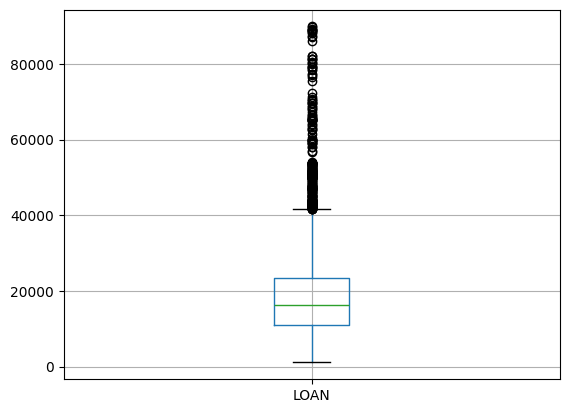

In [32]:
df.boxplot(column= 'LOAN')

As said, descriptive statistics are useful to understand the distribution of feature values. For example, we can see that the average loan amount (LOAN) is around 18,607 with a maximum of 89,900. This suggests that most loans are relatively small, but there are some potential outliers with much larger amounts. Similarly, the average debt-to-income ratio (DEBTINC) is around 30%, which is a common threshold for lenders to assess creditworthiness. However, we also see that some borrowers have a very high debt-to-income ratio of over 200, which suggests a much higher risk of default. This impression is supported by observing that the 75% quantile of the DEBTINC feature is around 39, meaning that the 75% smallest value of the debt-to-income ratio in this data set are less than or equal to 39; much lower than the observed maxium.

Overall, these statistics provide a good starting point for understanding the data and identifying potential issues or areas for further investigation.

### Data Visualisation

In this subsection, we take a graphical approach to advance our understanding of the dataset using the two most prominent libraries for data visualization – Matplotlib and Seaborn.

**Matplotlib**: A foundational plotting library, Matplotlib is the granddaddy of Python visualization tools. It offers immense flexibility and allows us to create a wide variety of charts and plots with fine-grained control over every aspect of the visuals. Whether it's histograms, scatter plots, or line charts, Matplotlib provides the functionalities to craft them all with detailed customizations.

**Seaborn**: Built on top of Matplotlib, Seaborn brings sophistication and simplicity to our visualizations. It's known for its stunning color palettes, elegant designs, and ease of use. While it integrates closely with Matplotlib, Seaborn simplifies many complex visual tasks, making sophisticated plots accessible and understandable. Notably, it excels in handling and representing complex datasets and statistical models — from heatmaps to regression line plots.


#### Histograms

Our first stop is the world of histograms — a type of plot that lets us see the frequency distribution of a single variable. By plotting histograms for all the features in our dataset, we can visually grasp the distribution of data points and detect any skewness or anomalies that might exist. This understanding is crucial as it directly influences how certain machine learning models might perform with our data.

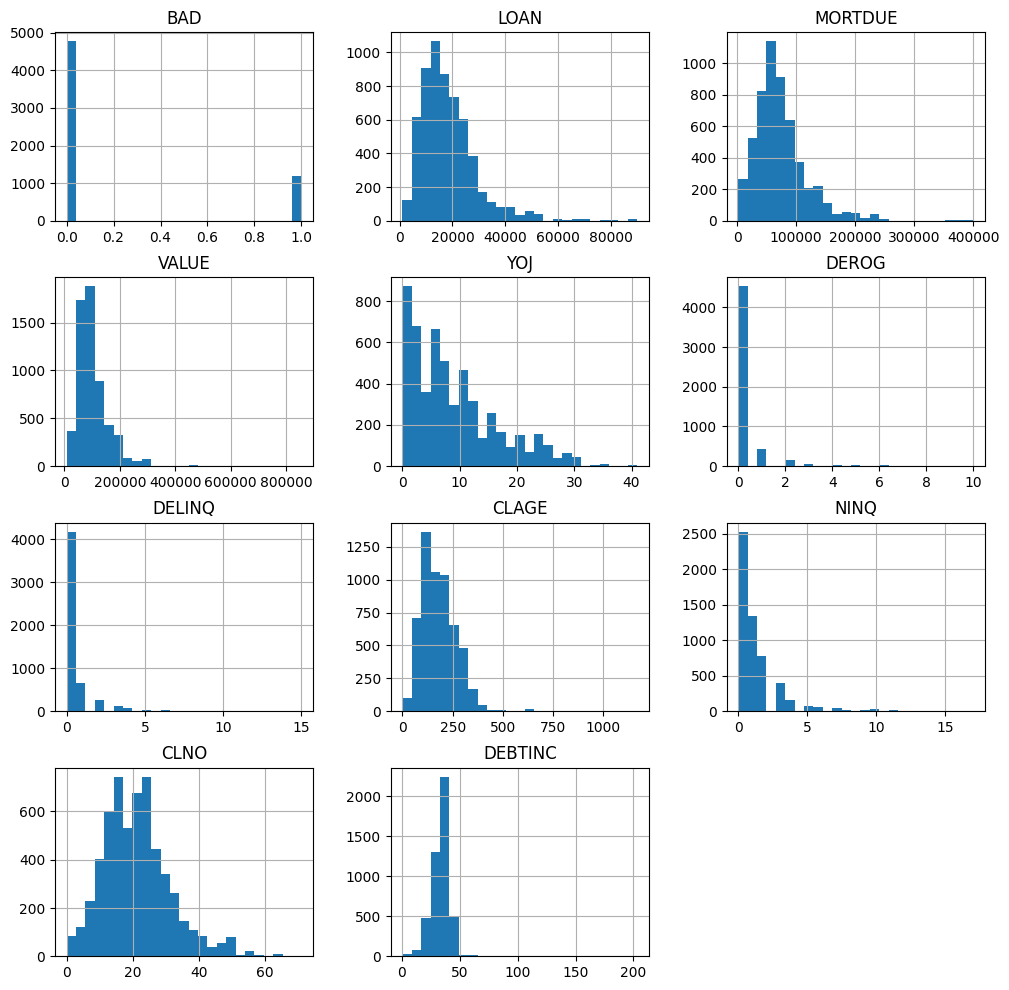

In [33]:
df.hist(figsize=(12, 12), bins=25);

Examining the distribution of individual features can inform further data preparation steps. For example, the feature ```DEROG ```, which captures the number of major derogatory reports, is zero for most customers and non-zero for only a relatively small sample of clients. One could speculate whether it is preferable to transform the feature into a binary indicator of whether a client received one or more major derogatory reports in the past or not. This might better represent the core information that this feature embodies for predicting the target.
Shifting attention to the feature ```LOAN ```, we can observe a *long tail* of a few clients having received loans much larger than those of what most clients lend. The same pattern is observable for the feature ```MORTDUE```. Again, features with such *right-skewed distributions* might become more useful if we apply a transformation, which could, for example, involve *[discretizing](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-discretization)* the feature.

Since we speak about the *informativeness* of a feature or how useful it is, it is important to point out that these statements refer to the focal use case. We strive to predict whether a credit application would repay a loan. In this context, a feature is useful if it helps predict applicants' repayment behavior. To obtain a clearer view, we can visualize our data as a stacked histogram, which displays the distribution of a feature for all good payers and bad payers separately. Here is how to do this.

 Since we need to do a little more coding to obtain a nice result, feel free to jump right to the resulting matrix of grouped histograms.

In [44]:
grouped = df.groupby('BAD')
numerical_features = df.select_dtypes(exclude=['O']).columns
print(numerical_features)
print(len(numerical_features))
n=len(numerical_features)
print(n)
ncols=3
print(n // ncols)

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')
11
11
3


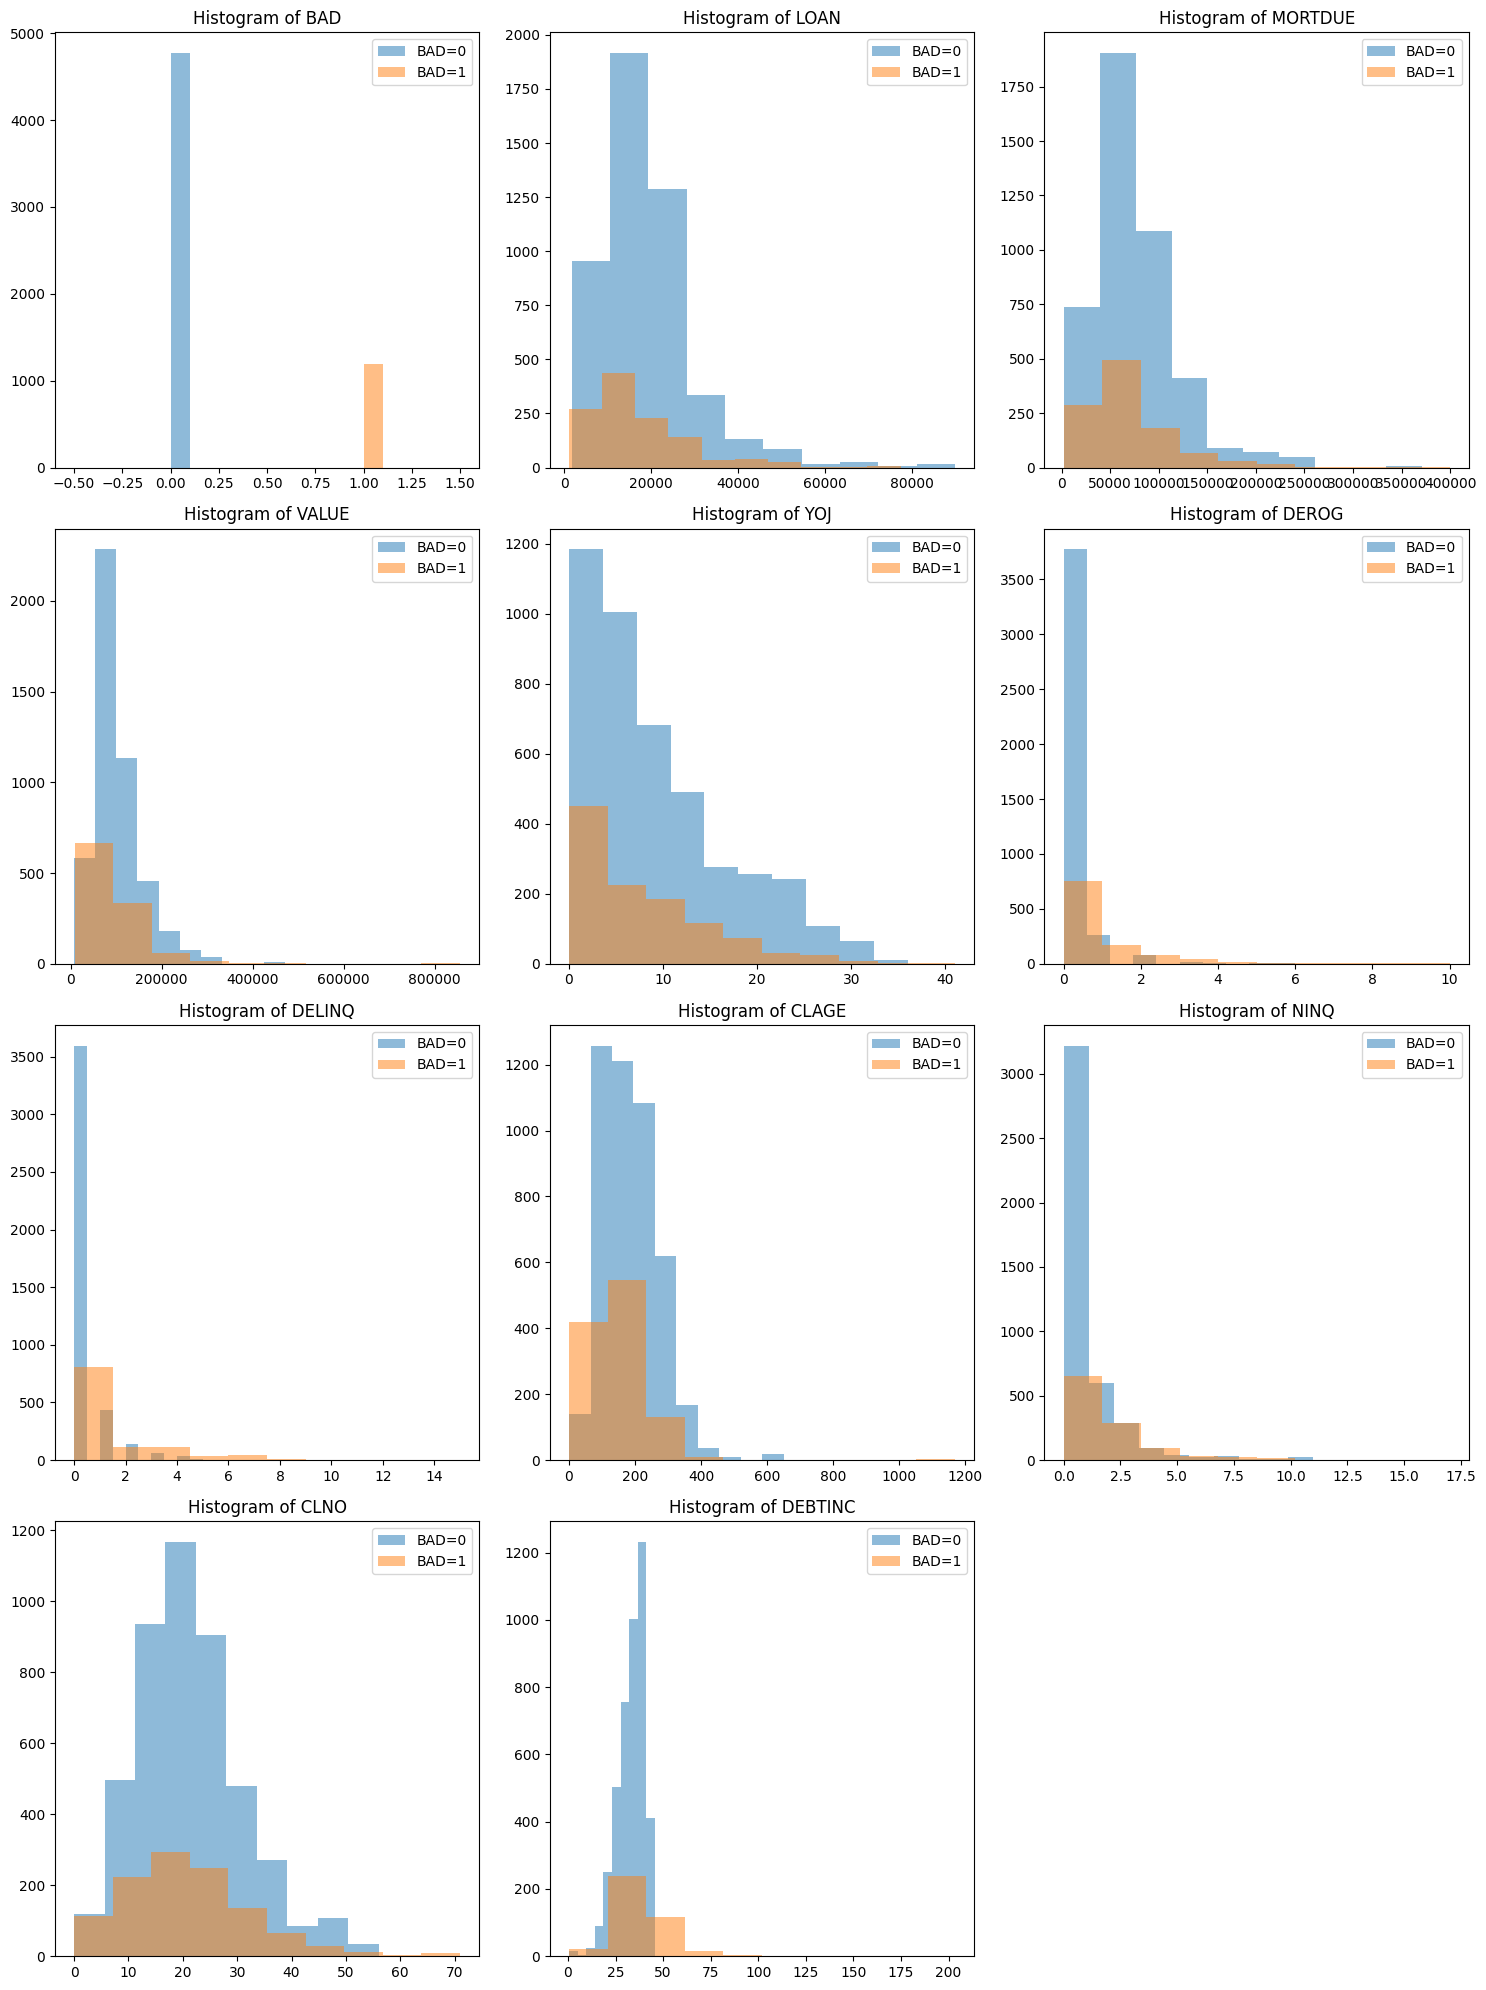

In [45]:
grouped = df.groupby('BAD')

# Get the list of numerical features
numerical_features = df.select_dtypes(exclude=['O']).columns

# Calculate the number of rows and columns for the subplots
n = len(numerical_features)
ncols = 3
nrows = n // ncols if n % ncols == 0 else n // ncols + 1

# Create a new figure for the subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows*5))

# Flatten the axes array
axs = axs.flatten()

# Iterate over each numerical feature
for i, feature in enumerate(numerical_features):
    # Iterate over each group and plot the histogram on the corresponding subplot
    for name, group in grouped:
        axs[i].hist(group[feature], alpha=0.5, label=f'BAD={name}')

    # Add a title and a legend to each subplot
    axs[i].set_title(f'Histogram of {feature}')
    axs[i].legend()

# Remove extra subplots
for i in range(n, nrows*ncols):
    fig.delaxes(axs[i])

# Display the plot
plt.tight_layout()
plt.show()

(11,)
(11, 11)


<Axes: >

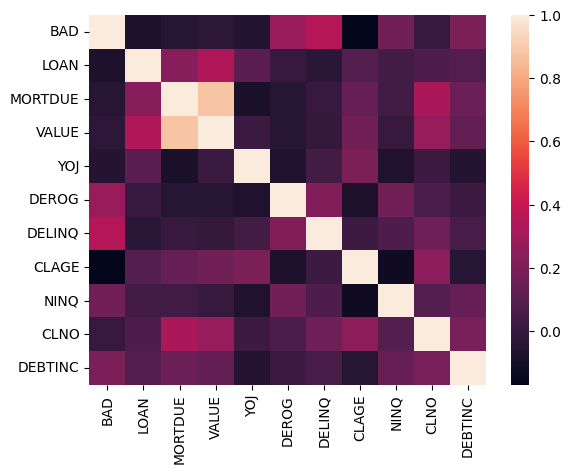

In [53]:
numeric_data = df.select_dtypes(include=['number'])
print(numeric_data.columns.shape)
correlations = numeric_data.corr().round(2)
print(correlations.shape)
sns.heatmap(correlations)

#### Correlation matrix

Next, we examine correlation heatmaps, which allow us to visualize the correlation matrix. Imagine being able to see, at a glance, how all the features in our dataset interact with one another. Are certain variables strongly positively correlated? Are others inversely related? These relationships, often non-discernable from raw numbers, become strikingly clear with a correlation heatmap. This step is invaluable, as understanding feature relationships can guide our feature selection and provide insights into the potential collinearity in our models.

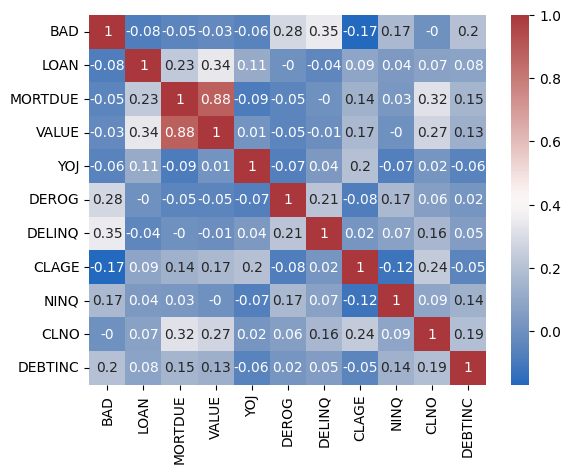

In [54]:
# Recall that our data has both, numerical (e.g. loan) and categorical (e.g., reason) information.
# Correlation is defined for numerical data only. Therefore, we first extract only the numerical
# columns from the data frame
numeric_data = df.select_dtypes(include=['number'])

# compute correlations
correlations = numeric_data.corr().round(2)  # note the beauty of pandas. We just 'ask' our data frame to give us
                                             # the correlations among features; very easy-to-read code
# plot correlation heatmap
sns.heatmap(correlations, cmap='vlag', annot=True);


We could discuss the above results in detail. And yet, arguably the most important correlation in our credit risk prediction context is the correlation between individual features and the  target. Let's extract it from the matrix to get a clear picture.

In [57]:
# Correlations of features with target:
print(correlations['BAD'].iloc[:-1])

BAD        1.00
LOAN      -0.08
MORTDUE   -0.05
VALUE     -0.03
YOJ       -0.06
DEROG      0.28
DELINQ     0.35
CLAGE     -0.17
NINQ       0.17
CLNO      -0.00
Name: BAD, dtype: float64


In [59]:
print(correlations)
print(correlations['BAD'])

          BAD  LOAN  MORTDUE  VALUE   YOJ  DEROG  DELINQ  CLAGE  NINQ  CLNO  \
BAD      1.00 -0.08    -0.05  -0.03 -0.06   0.28    0.35  -0.17  0.17 -0.00   
LOAN    -0.08  1.00     0.23   0.34  0.11  -0.00   -0.04   0.09  0.04  0.07   
MORTDUE -0.05  0.23     1.00   0.88 -0.09  -0.05   -0.00   0.14  0.03  0.32   
VALUE   -0.03  0.34     0.88   1.00  0.01  -0.05   -0.01   0.17 -0.00  0.27   
YOJ     -0.06  0.11    -0.09   0.01  1.00  -0.07    0.04   0.20 -0.07  0.02   
DEROG    0.28 -0.00    -0.05  -0.05 -0.07   1.00    0.21  -0.08  0.17  0.06   
DELINQ   0.35 -0.04    -0.00  -0.01  0.04   0.21    1.00   0.02  0.07  0.16   
CLAGE   -0.17  0.09     0.14   0.17  0.20  -0.08    0.02   1.00 -0.12  0.24   
NINQ     0.17  0.04     0.03  -0.00 -0.07   0.17    0.07  -0.12  1.00  0.09   
CLNO    -0.00  0.07     0.32   0.27  0.02   0.06    0.16   0.24  0.09  1.00   
DEBTINC  0.20  0.08     0.15   0.13 -0.06   0.02    0.05  -0.05  0.14  0.19   

         DEBTINC  
BAD         0.20  
LOAN        0

Correlation ranges from -1 to 1, with 1 indicating a perfect positive relationship, 0 indicating no relationship, and -1 indicating a perfect negative relationship. Thus, the correlation results give us an indication of which of the features are more or less associated with the target variable. However, our target is binary, which means that we have to take standard correlation statistics with a grain of salt.

### Missing Values

As already noted above, our data contains missing values. Missing values are common when working with real data. Likewise, handling missing values is a standard task in data preparation. Let's see how Pandas supports handling missing values. The function `.isnull()` is the entry point to the corresponding functionality and helps with identifying the relevant cases.

In [61]:
df.isnull().head()  # Boolean mask to access missing values

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,False,False,False,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,False,False,True
3,False,False,True,True,True,True,True,True,True,True,True,True,True
4,False,False,False,False,False,False,False,False,False,False,False,False,True


In [63]:
print(df.isnull().sum())
print(df.isnull().sum().sum())

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64
5271


We can easily count the total number of missing values as shown below. Pause here and make sure you fully understand why we call the `sum()` function twice. If unsure, just remove one of the calls to `sum()` and examine how the output changes.

In [64]:
n_missing = df.isnull().sum().sum()  # count the total number of missing values
print('Total number of missing values is {}'.format(n_missing))

Total number of missing values is 5271


In [66]:
print('{} Total number of missing values is'.format(n_missing))

5271 Total number of missing values is


Heatmaps are a useful way to obtain an overview of the missingness in the data. For example, we will see immediately which of the features are most affected.

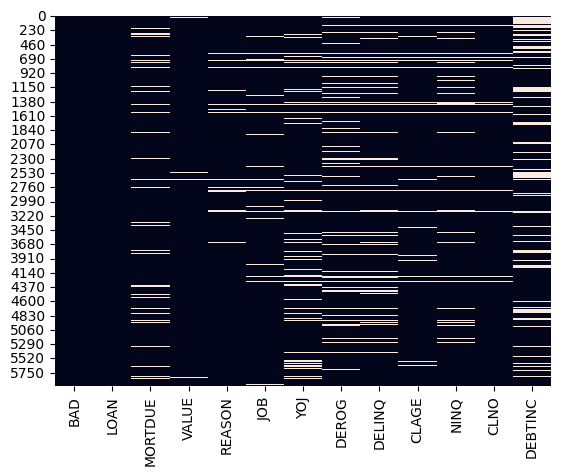

In [67]:
sns.heatmap(df.isnull(), cbar=False);  # quick visualization of the missing values

While missing data is very common, there is no principled way of dealing with this problem. A whole stream of literature is devoted to researching the missing data problem (see, e.g., [Peng et al. (2022)](https://doi.org/10.1287/isre.2022.1104) if interested) and we can easily spend a whole course on that topic. We certainly won't. Instead, we take a crude approach of simply replacing any missing value in the data set with the *mean* of the corresponding column, which we compute over the observed feature values. Please be aware that this approach is highly problematic. It is a shortcut we use here for convenience.

The above being said, here is code to replace missing values in numerical and categorical columns by the mean and mode of the corresponding column, respectively.


In [76]:
for column in df.columns:  # loop through all the columns (i.e., features)
    if df[column].dtype == 'O':  # decide on the imputation strategy based on the data type
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].mean(), inplace=True)

<ipython-input-76-357b235eb134>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)
<ipython-input-76-357b235eb134>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [75]:
print(df.columns)
df['JOB'].mode()

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')


,JOB
0,Other


At this point, you could re-use some of the previous code for testing whether a data set includes missing values to verify that we have successfully imputed all missing values in the data set. Likewise, you could re-create the plots and examine how our naive missing value imputation has altered the distribution of some features.  

In [79]:
df.isna().sum().sum()

np.int64(0)

In [82]:
df['BAD'].dtype
y = df['BAD'].astype(float)
y.dtype

dtype('float64')

Before making any further changes to our data set, we will partition the data into two parts, storing the true outcomes (i.e., class labels) in one array while storing the feature values for all observations in another (2D) array. In the course, we introduced standard notation to refer to the true outcomes and the matrix of feature values with symbols $y$ and $X$, respectively. Hence, we use these symbols in the following.

In [110]:
# Define the feature and target variables and converts everything to numbers
# due to requirements of the statsmodel library
y = df['BAD'].astype(float)
X = df.drop(columns='BAD')


In [111]:
X

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1100,25860.0000,39025.000000,HomeImp,Other,10.500000,0.00000,0.000000,94.366667,1.000000,9.000000,33.779915
1,1300,70053.0000,68400.000000,HomeImp,Other,7.000000,0.00000,2.000000,121.833333,0.000000,14.000000,33.779915
2,1500,13500.0000,16700.000000,HomeImp,Other,4.000000,0.00000,0.000000,149.466667,1.000000,10.000000,33.779915
3,1500,73760.8172,101776.048741,DebtCon,Other,8.922268,0.25457,0.449442,179.766275,1.186055,21.296096,33.779915
4,1700,97800.0000,112000.000000,HomeImp,Office,3.000000,0.00000,0.000000,93.333333,0.000000,14.000000,33.779915
...,...,...,...,...,...,...,...,...,...,...,...,...
5955,88900,57264.0000,90185.000000,DebtCon,Other,16.000000,0.00000,0.000000,221.808718,0.000000,16.000000,36.112347
5956,89000,54576.0000,92937.000000,DebtCon,Other,16.000000,0.00000,0.000000,208.692070,0.000000,15.000000,35.859971
5957,89200,54045.0000,92924.000000,DebtCon,Other,15.000000,0.00000,0.000000,212.279697,0.000000,15.000000,35.556590
5958,89800,50370.0000,91861.000000,DebtCon,Other,14.000000,0.00000,0.000000,213.892709,0.000000,16.000000,34.340882


### Category Encoding
Some more preparatory steps are needed. Many machine learning methods including regression-type methods cannot process categorical data directly. Therefore, we first encode categorical features by transforming them into several binary features. This approach is standard practice and often called [dummy coding](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features)

In [112]:
cat_features = ['REASON', 'JOB']  # these are the categorical features in need of transformation

# Create a new data frame with all the numerical features and the
# categorical features dummy-encoded
X = pd.get_dummies(X, columns=cat_features, drop_first=True)

# consider examining the columns in new data frame. At this point,
# you know at least two Pandas functions to do so ;)



In [120]:
X.mean()

,0
LOAN,18607.969799
MORTDUE,73760.817200
VALUE,101776.048741
YOJ,8.922268
DEROG,0.254570
DELINQ,0.449442
CLAGE,179.766275
NINQ,1.186055
CLNO,21.296096
DEBTINC,33.779915


### Scaling
One more step and we are ready. It is good practice to scale the values of numerical features before applying any machine learning method. Scaling will ensure that the value ranges for all features are comparable. Imagine two hypothetical features salary and number of childeren. Without scaling, their values would be much different, with salary being measures in, e.g., thousands of euros whereas plausible values for the feature number of kids will be between 0 and, let say 5 ;). Scaling removes these discrepancies in value ranges and puts all numerical features on a common scale.  

In [124]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X = pd.DataFrame(sc.fit_transform(X), columns=X.columns)

# Again: consider exploring the data after this last preparation step

## 2. Explanatory Modeling
As we transition into Section 2, we shift our focus from exploration to explanation. Unlike predictive modeling, the primary goal here is not to make predictions on unseen data but to understand the relationships within the data. More specifically, we will fit a *logistic regression model* to examine how our features affect the target variable. To that end, we will use the library `statsmodels` and delve into interpreting the `summary()` output, which this library produces. The corresponding insight including, e.g., fitting statistics, p-values of regression coefficients, etc. is not just crucial for data science but invaluable across various research fields.

### Logistic Regression
We are ready to proceed with estimating our explanatory logistic regression model.

In [133]:
import statsmodels.api as sm

# Create and fit a linear regression model
model = sm.Logit(y, sm.add_constant(X))
result = model.fit()

# Print the summary of the model
print(result.summary())



Optimization terminated successfully.
         Current function value: 0.392532
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 5960
Model:                          Logit   Df Residuals:                     5943
Method:                           MLE   Df Model:                           16
Date:                Wed, 14 May 2025   Pseudo R-squ.:                  0.2145
Time:                        11:20:13   Log-Likelihood:                -2339.5
converged:                       True   LL-Null:                       -2978.2
Covariance Type:            nonrobust   LLR p-value:                3.442e-262
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.6885      0.041    -41.042      0.000      -1.769      -1.608
LOAN             

Since prior classes have introduced you to regression analysis, the above output will look  familiar. In a nutshell, it sheds light on how well the logistic regression model explains the data, how features relate to the target, and for which features we find sufficient evidence to conclude that their effect on the target is not random but statistically significant. No worries if these terms do not make sense to you. We can discuss the output in the practical and don't forget, this notebook is to demonstrate a typical modeling pipeline to ready us for future programming sessions.

## 3. Predictive Modeling
Entering Section 3, we embark on the realms of predictive modeling or supervised machine learning. Here, our goal is to make accurate predictions on new, unseen data. Put differently, we aim to predict the future state of a borrower, whether s/he would repay a loan or not.
To achieve this, we consider two popular machine learning algorithms, a linear logistic regression model and a more complex gradient boosted tree model. You'll see how to i) organize your data by performing a train-test split, ii) fit the prediction model, and iii) fine-tune an XGBoost classifier using k-fold cross-validation and grid search. By the end of this section, you'll have foundational yet powerful tools in your data science arsenal, ready to tackle real-world predictive tasks.

### Logistic Regression Reloaded
We start by applying logistic regression, just as before. Here, however, we emphasize the application of logistic regression for prediction. A key to effective predictive modeling is not only in how well we fit our model to the data but also in how well our model generalizes to new, unseen data. This is where the concept of *train-test spliting* comes into play. This technique involves dividing our dataset into two subsets:

- **Training set**: A portion of the data used to train the model. The model sees and learns from this data.
- **Testing set**: A portion of the data unseen by the model during training, used to test how well the model performs on new data.

This separation is crucial for assessing our model's performance and robustness because it ensures that we have a reserved dataset that the model hasn't seen before, simulating how the model is expected to perform in real-world scenarios. It protects against overfitting – a common pitfall where a model performs well on the training data but poorly on new, unseen data – ensuring that our model is not only accurate but also reliable and generalizable.

In [139]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=888)
# This code splits the dataset into training and testing sets, with `X` representing the input features and `y` representing the target variable.
# The split ratio is 70% for training and 30% for testing, and the `random_state=888` ensures reproducibility of the split.

In [142]:
print('X_train shape: ' , X_train.shape)
print('X_test shape: ' , X_test.shape)
print('y_train shape: ' , y_train.shape)
print('y_test shape: ' , y_test.shape)
print(X_train.dtypes)

X_train shape:  (4172, 16)
X_test shape:  (1788, 16)
y_train shape:  (4172,)
y_test shape:  (1788,)
LOAN              float64
MORTDUE           float64
VALUE             float64
YOJ               float64
DEROG             float64
DELINQ            float64
CLAGE             float64
NINQ              float64
CLNO              float64
DEBTINC           float64
REASON_HomeImp    float64
JOB_Office        float64
JOB_Other         float64
JOB_ProfExe       float64
JOB_Sales         float64
JOB_Self          float64
dtype: object


In [143]:
# Fit a logistic regression model using sklearn
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression().fit(X_train, y_train)



In [148]:
logit.coef_
logit.intercept_

array([-1.70496359])

But our journey doesn't end with training a model. We also want to compute predictions and assess their accuracy. To accomplish this, we'll assess the quality of these predictions by comparing actual outcomes (whether a loan was paid back) to predicted outcomes usaing our test data. The *confusion matrix* is a widely used approach to depict the corresponding results graphically.

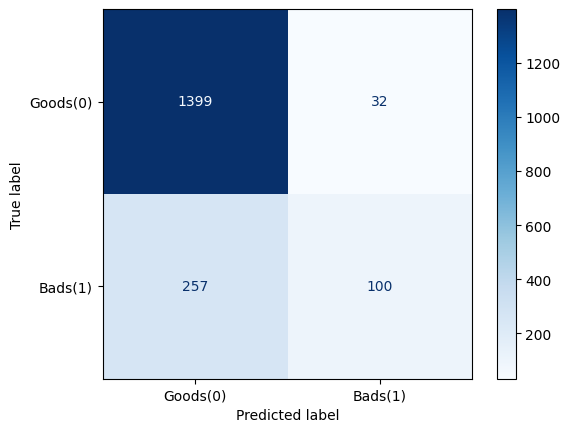

In [149]:
# Compute Root Mean Squared Error (RMSE) for the linear model
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(logit, X_test, y_test, labels=[0, 1],
                                      display_labels=['Goods(0)', 'Bads(1)'], cmap='Blues',values_format='n')
plt.show()

Although we have not discussed the evaluation of classification models at all, the confusion matrix plot is somewhat intuitive. Take a little time to check it and convince yourself that our first prediction model did a very poor job.  

### XGBoost
Perhaps a more powerful learning algorithm can do better. XGBoost, short for [eXtreme Gradient Boosting](https://arxiv.org/abs/1603.02754), is an advanced implementation of the [gradient boosting paradigm](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/). So, what is gradient boosting? At its heart, it's a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weaker prediction models, typically decision trees. It builds the ensemble in a stage-wise fashion where models are added sequentially until no further improvements can be made.

XGBoost is widely used in machine learning competitions and real-world applications, not only because of its speed and performance but also because it has proven to be a highly accurate learning algorithm. It's versatile – it supports regression, classification, ranking, and user-defined prediction problems.

**Caution:** Before running the next code cell, please make sure you have installed the `xgboost` library on your system. If not, you can do so using the command:
```
!pip install xgboost
```

In [150]:
# Create an XGBoost classifier (we set a few parameters to avoid warning messages. Just ignore them for now)
import xgboost as xgb

xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

When working with more complex models like XGBoost, several parameters need fine-tuning to enhance the model's predictive performance. In the case of XGBoost, three pivotal ones are:

1. **Tree Depth**: This represents the depth of the decision trees in the ensemble. Deeper trees can capture more complex patterns by adding more decision nodes, but they also risk overfitting the training data. Conversely, shallower trees might underfit, missing crucial information.
   
2. **Learning Rate**: This is a crucial hyperparameter that controls the impact of each additional tree on the final outcome in the boosting process. A smaller learning rate means the model is more robust to overfitting. However, it will train more slowly and require more trees to model all relations between features and targets. A larger learning rate leads to faster training but can overshoot the optimal point.
   
3. **Number of estimators**: This denotes the number of trees you want to build. In general, a higher number of trees increases the model's performance, but after a certain point, the benefit in prediction performance becomes negligible, and it might overfit to the data.

Adjusting these parameters requires a systematic approach, and this is where grid search comes into play. Grid search is a method for hyperparameter tuning that involves constructing multiple versions of the model, each with a different combination of settings, and selecting the combination that performs the best. In simpler terms, imagine trying every spot on a grid for the best view of a landscape, rather than just guessing and checking random spots.

However, how do we ensure that the combination selected is truly the best and not just lucky due to some quirk in the way we split our data? This brings us to k-fold Cross-Validation (CV).

k-fold CV is a resampling procedure used to evaluate a model on a limited data sample. The process divides the dataset into k number of subsets (or folds) of equal size. It then iteratively trains the model k times, each time training the data on k-1 of the folds and evaluating it on the kth fold. After running these iterations, the results are averaged to provide a single estimation. The primary reason for using this method is to limit problems like overfitting or underfitting and get a sense of how the model will generalize to an independent dataset.

In our case, we're using a 5-fold CV. This means each dataset is split into 5 parts, the model is trained on 4 parts and validated on the remaining part, iteratively.

Combining grid search with cross-validation provides a robust method for optimizing a model's hyperparameters. We're not only searching for the best parameters, but we're also ensuring they produce a model that generalizes well.

In [151]:
# Perform grid search with cross-validation to find the best parameters
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for the grid search
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 250],
}

# Set the number of cross-validation folds
cv_folds = 5

In [152]:
# Run the grid search using sklearn's built-in GridSearchCV function
grid_search = GridSearchCV(xgb, param_grid, cv=cv_folds, scoring='roc_auc', verbose=1).fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:04:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:04:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:04:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:04:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:04:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 4, 5],
                         'n_estimators': [100, 250]},
             scoring='roc_auc', verbose=1)

The grid search and cross-validation process has identified one most suitable XGB configuration. At this point, we proceed with evaluating this *most competent* classifier and assess its performance on hold-out data, using the same approach as before for the logistic regression model.

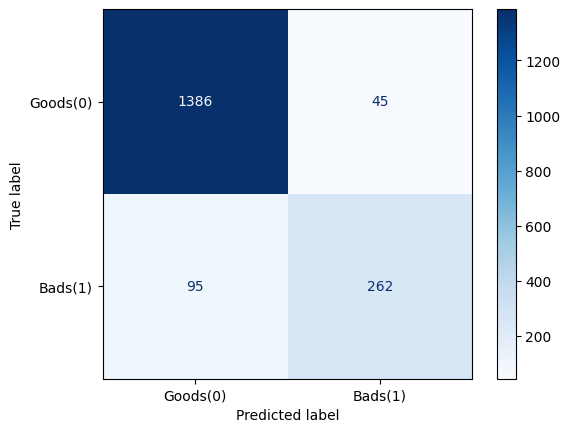

In [156]:
# Get the best XGBoost model from the grid search
best_xgb_model = grid_search.best_estimator_

ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test, y_test, labels=[0, 1],
                                      display_labels=['Goods(0)', 'Bads(1)'], cmap='Blues',values_format='n')
plt.show()

Let's boil down the evaluation of XGB versus logistic regression to two easily compared numbers, the share of correct classifications for each model.

In [157]:
print('Classification accuracy of XGBoost: {:.2f} %'.format(best_xgb_model.score(X_test, y_test)*100))
print('Classification accuracy of Log. Reg.: {:.2f} %'.format(logit.score(X_test, y_test)*100))

Classification accuracy of XGBoost: 92.17 %
Classification accuracy of Log. Reg.: 83.84 %


### ROC Analysis
Another even more popular way to compare the predictive performance of binary classification models is *ROC analysis*.

A ROC curve is a plot that displays the true positive rate against the false positive rate for every possible decision threshold of classifier¹²In our context, t The true positive rate is the proportion of good payers (i.e., `BAD==0`) that are correctly classified as good payers, and the false positive rate is the proportion of bad payers that are incorrectly predicted as good payers.

The closer the ROC curve is to the top left corner of the plot, the better classifier's performance. A perfect model has a ROC curve that passes through the top left corner, representing 100% sensitivity (no false negatives) and 100% specificity (no false positives). A model whose predictions are 100% wrong has a ROC curve that passes through the bottom right corner. The ROC curve of a random model is just a straight line from the point (0,0) to the point (1,1).

To compare different models, we can calculate the Area Under the Curve (AUC). The AUC ranges from 0 to 1. An AUC value of 1 means the model is perfect, and an AUC of 0.5 represents a model that makes random prediions. The larger the AUC, the better the model's ability to distinguish between the two classes.

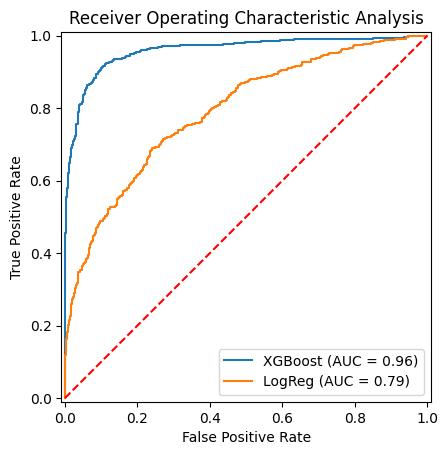

In [158]:
from sklearn.metrics import RocCurveDisplay

# Create a new figure
fig, ax = plt.subplots()

# Compute ROC curve and ROC area for XGB and plot on ax
RocCurveDisplay.from_estimator(best_xgb_model, X_test, y_test, ax=ax, name='XGBoost')

# Compute ROC curve and ROC area for logit and plot on same ax
RocCurveDisplay.from_estimator(logit, X_test, y_test, ax=ax, name='LogReg')

# Add labels and title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic Analysis')

# Add diagonal to depict random classifier
ax.plot([0, 1], [0, 1], "r--")

plt.show()

**Interpretation**:
the plot emphasizes the superior performance of XGBoost over logistic regression. For example, we see that it consistently achieves higher true positive rate when showing the same false positive rate. We also learn from the legend of the plot that XGBoost has much higher area under the curve (AUC).

## 4. Post-hoc Analysis
In our final section, we'll dissect our models post-training to understand not just what predictions a model makes but how and why it makes them. This section emphasizes the importance of model interpretability, an often overlooked aspect of machine learning. We'll compare feature importance between our models using XGB feature importance and Linear Regression coefficients, helping us understand which variables our models deem most significant. Additionally, we'll dive into Partial Dependence Plots (PDPs) for nuanced insight into how specific features influence our model's predictions across different models. This section underscores that our job doesn't end at model training; understanding and interpreting our models is equally, if not more, important.

### XGBoost feature importance

In the realm of machine learning, the journey doesn't end once a model is trained and its performance evaluated; understanding what drives predictions is crucial, especially in applications demanding interpretability and transparency. This is where the concept of feature importance becomes invaluable. Feature importance provides insights into the trained model by indicating how much each feature contributed to the model's predictions, whether in terms of improving accuracy, reducing impurity, or another metric.

One critical metric here is "gain," which refers to the improvement in accuracy brought by a feature to the branches it is on. The higher the gain score, the more essential the feature is in contributing to the model's predictive power. Gain is calculated as the total gain of a feature's splits, averaged over all the trees in the model.

The Python XGBoost implementation allows us to extract importance scores for each feature, allowing us to see which variables are most influential in predicting the target variable. This information is vital for several reasons: it contributes to a better understanding of the underlying data and the model, it identifies potential areas of focus for feature engineering, and it enhances the interpretability of the model by highlighting the significant features.

In [159]:
# Extract feature importances from the XGBoost model
feature_importances = best_xgb_model.get_booster().get_score(importance_type='gain')

Now we can visualize the feature importances as a bar plot:

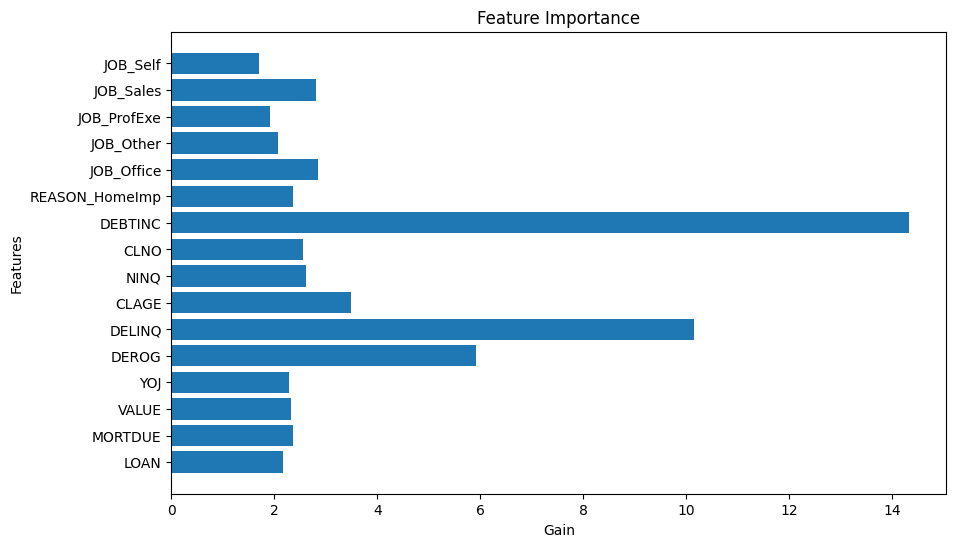

In [160]:
# Create lists of feature names and corresponding gains
features = list(feature_importances.keys())
gains = list(feature_importances.values())

# Create a bar plot
plt.figure(figsize=(10, 6))

# Using barh to create a horizontal bar plot
plt.barh(features, gains)
plt.title('Feature Importance')
plt.xlabel('Gain')
plt.ylabel('Features')

# Show plot
plt.show()

We cannot yet know how specifically *gain* is computed. But this does not matter (yet). From the plot, it is immediately clear which of the features were most important to the XGB model. It is appealing to see that features like the debt-to-income ratio or the number of major derogatory reports come out as most relevant. These are exactly the features a domain expert would identify as highly important. Results like this can help build trust in a machine learning model.

However, feature importance alone does not suffice to tell a compelling story. This is where the concept of *partial dependence* comes in handy.

### Partial Dependence Plot

Partial Dependence Plots are a visualization tool used for exploring the relationship between a set of features and the predictions of the machine learning model while averaging out the effect of other features. These plots allow us to visualize how changes in a feature's values affect the predictions of the model, assuming that all other features remain constant. This is especially valuable when dealing with complex models like ensemble trees or neural networks, where it's not immediately clear how a model arrives at its predictions.

The power of PDPs extends beyond just interpretation; they help in validating whether the model's behavior aligns with domain knowledge, identifying potential areas for feature engineering, and detecting regions in the feature space where the model might underperform or be overly confident.

In the following, we're going to generate Partial Dependence Plots for our models. We'll analyze how the screen size in inches impacts our resale price predictions, providing us with deeper insights not just into our data, but also into the model's inner workings.

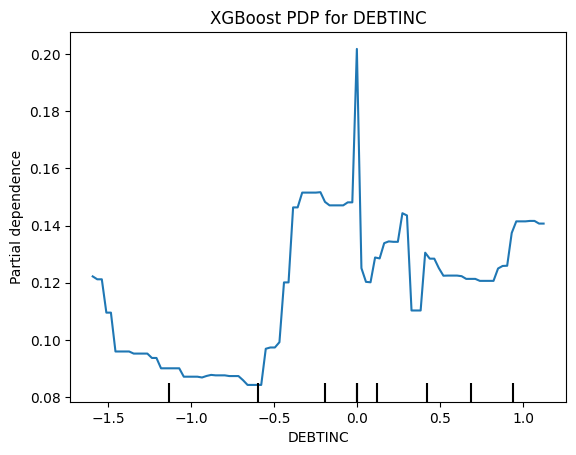

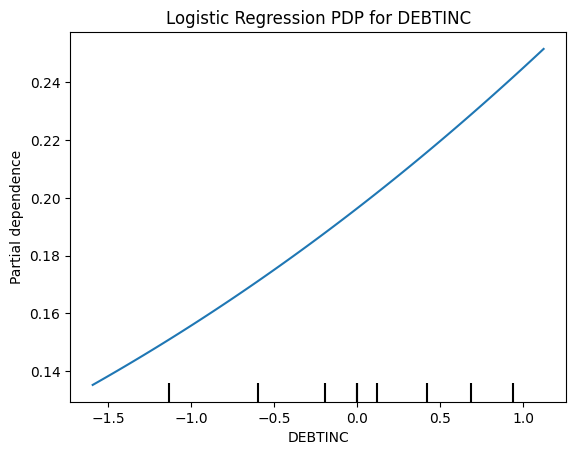

In [161]:
# Import the necessary libraries for partial dependence display
from sklearn.inspection import PartialDependenceDisplay

# Select the feature you want to analyze (e.g., 'MedInc')
feature_to_plot = 'DEBTINC'

# Create a PartialDependenceDisplay object for XGBoost model
xgb_partial_dependence_display = PartialDependenceDisplay.from_estimator(
    best_xgb_model, X_train, features=[feature_to_plot]
)
plt.title(f'XGBoost PDP for {feature_to_plot}')
plt.show()

# Create a PartialDependenceDisplay object for the logistic regression model
linear_partial_dependence_display = PartialDependenceDisplay.from_estimator(
    logit, X_train, features=[feature_to_plot]
)
plt.title(f'Logistic Regression PDP for {feature_to_plot}')
plt.show()

Logistic regression is a linear model. Seeing that it models a linear relationship between the feature `DEBTINC` and the target should not come as a surprise. The plot will just look the same for any other feature. For XGBoost, on the other hand, we see how the classifier models a nonlinear pattern.

### SHAP
Since we speak about machine learning model explanation, the paradigm of *Shapely Additive Explanations (SHAP)* has emerged as a quasi-standard to diagnose - or "to XAI" - machine learning models. How this works?

Imagine a machine learning model as a team of players in a game. Each player represents a feature in your data. Now, the team's overall performance depends on each player's contribution. But how do we measure each player's contribution? That's where SHAP comes in. It uses a concept from cooperative game theory called the Shapley value to fairly distribute the "contribution" among the players. In other words, it tells us how much each feature in your data contributes to the model's decision; that is prediction.

Below, we demonstrate how SHAP can shed light on feature importance and partial dependence. However, note that this is only a small part of its functionality.

**Caution**: Again, it might be necessary to first pip-install the SHAP library before running the following code. If so, simply run:

```
!pip install shap
```

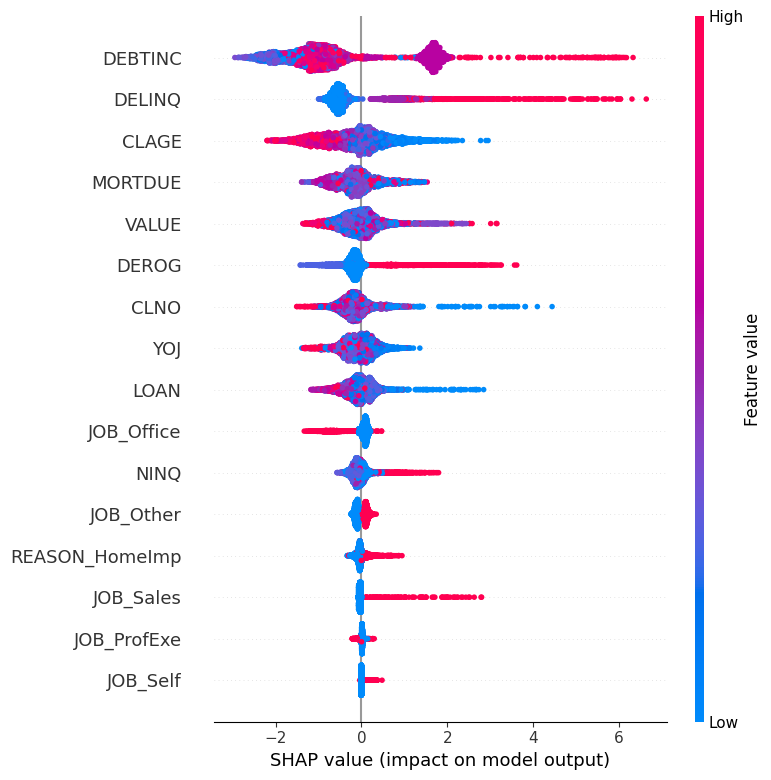

In [162]:
import shap

# Create the explainer
explainer = shap.Explainer(best_xgb_model)

# Calculate SHAP values
shap_values = explainer(X)

# Create the SHAP summary plot, which depicts feature importance
shap.summary_plot(shap_values, X)

While looking a lot more complicated, the summary plot conveys similar information as the above feature importance plot. Admittedly, seeing this is not straightforward, but also not essential at this point. We will have a closer look at SHAP in our last session. To finish the demo, let's also take a look at the SHAP analog to the partial dependence plot.

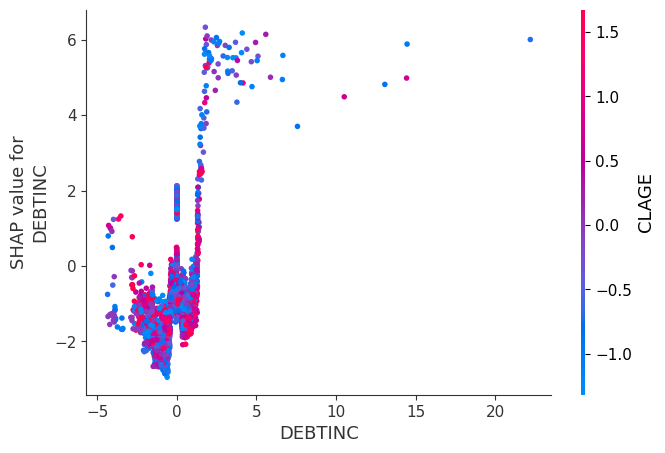

In [163]:
# Let's assume 'feature' is the name of the feature for which you want to create the plot
feature = 'DEBTINC'

# Create a SHAP dependence plot
shap.dependence_plot(feature, shap_values.values, X)